In [223]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from src.api.oil_price import OilPriceAPI

# Change matplotlib font to LaTeX-like
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Load Data

In [224]:
oil_price_api = OilPriceAPI()
df = oil_price_api.get_heizoel(plz=77716, start_date="2024-01-01")

df["Date"] = pd.to_datetime(df["Date"])

In [225]:
df.head(5)

,Price,Date,Measurement,PLZ
811,103.49,2024-01-01,EUR/100L,77716
812,104.21,2024-01-02,EUR/100L,77716
813,103.38,2024-01-03,EUR/100L,77716
814,102.19,2024-01-04,EUR/100L,77716
815,101.95,2024-01-05,EUR/100L,77716


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 811 to 1096
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Price        286 non-null    float64       
 1   Date         286 non-null    datetime64[ns]
 2   Measurement  286 non-null    object        
 3   PLZ          286 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.2+ KB


# Visualize Time Series

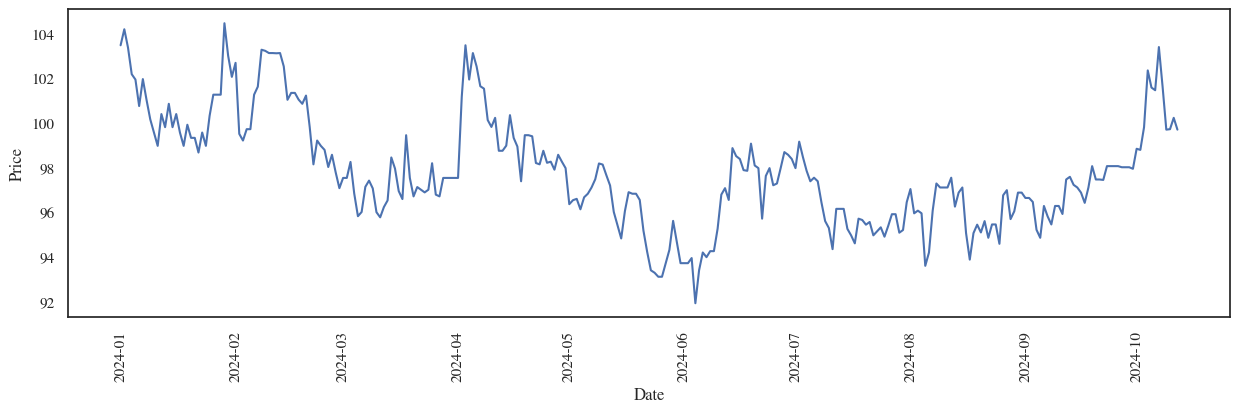

In [227]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))
sns.lineplot(data=df, x="Date", y="Price", ax=axes)
axes.tick_params(axis="x", labelrotation=90)
plt.show()

# Scale price variable with its max value

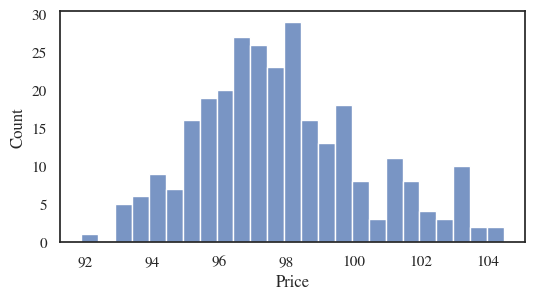

In [228]:
y = df["Price"]# / df["Price"].max()

fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(y, bins = 25)
plt.show()

In [229]:
# Drop non informative features
X = df.drop(["Price", "Measurement", "PLZ"], axis="columns")
X.index = X["Date"]
X

,Date
Date,
2024-01-01,2024-01-01
2024-01-02,2024-01-02
2024-01-03,2024-01-03
2024-01-04,2024-01-04
2024-01-05,2024-01-05
...,...
2024-10-08,2024-10-08
2024-10-09,2024-10-09
2024-10-10,2024-10-10


In [230]:
def create_time_features(df):
    """Create time features from date index
    :param df: pd.DataFrame -- Dataframe that has an date index
    :return: df: pd.DataFrame -- With time features populated df
    """
    df = df.copy()
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    df = df.drop(["Date"], axis="columns")

    return df

X = create_time_features(X)
X

,dayofmonth,dayofweek,quarter,month,year,dayofyear
Date,,,,,,
2024-01-01,1,0,1,1,2024,1
2024-01-02,2,1,1,1,2024,2
2024-01-03,3,2,1,1,2024,3
2024-01-04,4,3,1,1,2024,4
2024-01-05,5,4,1,1,2024,5
...,...,...,...,...,...,...
2024-10-08,8,1,4,10,2024,282
2024-10-09,9,2,4,10,2024,283
2024-10-10,10,3,4,10,2024,284


In [243]:
from typing import Union

def train_test_split(X, y, last_k_percent: Union[int, float] = 0.1):
    """Function to split X and y to train and test sets, where the last k percent is used for the testing.

    :param X: pd.DataFrame -- Train Data
    :param y: pd.DataFrame -- Labels
    :param last_k_percent: Union[int, float] -- Last k percent, or last k days
    :return: X_train, y_train, X_test, y_test, k
    """
    N = len(X)
    if isinstance(last_k_percent, float):
        # Get last k percent as absolute value
        k = int(N * last_k_percent)
    else:
        k = last_k_percent

    # Get first N-k values, e.g. first 250 values
    X_train = X.iloc[:(N-k)]
    y_train = y.iloc[:(N-k)]
    # Get last k values, e.g. last 50 values
    X_test = X.iloc[-k:]
    y_test = y.iloc[-k:]

    return X_train, y_train, X_test, y_test, k


X_train, y_train, X_test, y_test, k = train_test_split(X=X, y=y, last_k_percent=0.1)

y_train = pd.DataFrame(y_train)

In [248]:
from sklearn.ensemble import GradientBoostingRegressor

regr = GradientBoostingRegressor()
regr.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor()

In [256]:
y_pred = regr.predict(X_test)
# Convert to pd.DataFrame
y_pred = pd.DataFrame(y_pred, columns=["Price"], index=y_test.index)

y_pred

,Price
1069,97.015699
1070,96.851421
1071,96.742979
1072,96.742979
1073,96.865133
1074,97.029001
1075,96.892559
1076,96.678961
1077,96.828411
1078,96.719970


In [250]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, root_mean_squared_error

regr_metrics = [mean_absolute_percentage_error, mean_absolute_error, r2_score, root_mean_squared_error]
for metric in regr_metrics:
    val = metric(y_test, y_pred)
    print(f"{metric.__name__}: {val:.4f}")

mean_absolute_percentage_error: 0.0190
mean_absolute_error: 1.9061
r2_score: -1.0884
root_mean_squared_error: 2.5630


In [251]:
y_train

,Price
811,103.49
812,104.21
813,103.38
814,102.19
815,101.95
...,...
1064,96.27
1065,95.91
1066,97.46
1067,97.58


In [253]:
y_train["flag"] = "train"
y_pred["flag"] = "prediction"

y_combined = pd.concat([y_train, y_pred])
y_combined

,Price,flag
811,103.490000,train
812,104.210000,train
813,103.380000,train
814,102.190000,train
815,101.950000,train
...,...,...
1092,97.022842,prediction
1093,97.022842,prediction
1094,97.149882,prediction
1095,97.239660,prediction


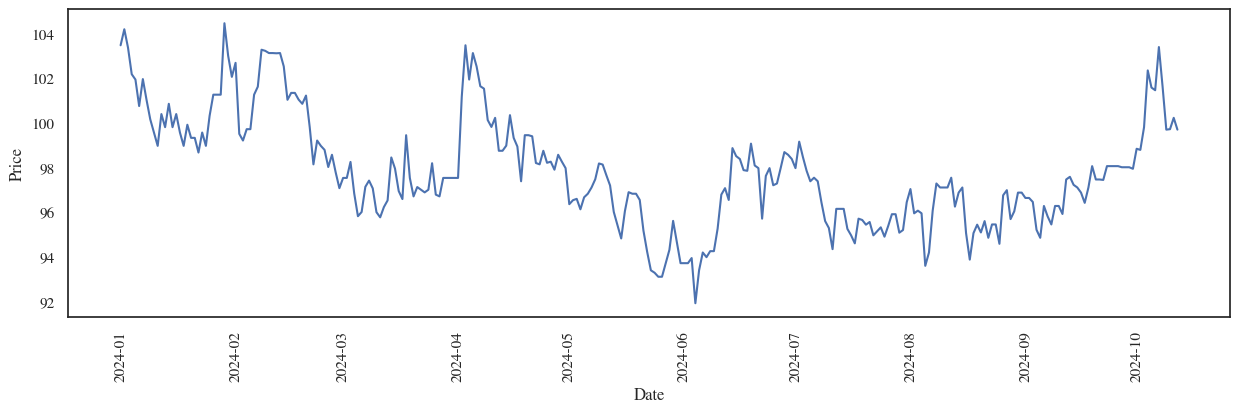

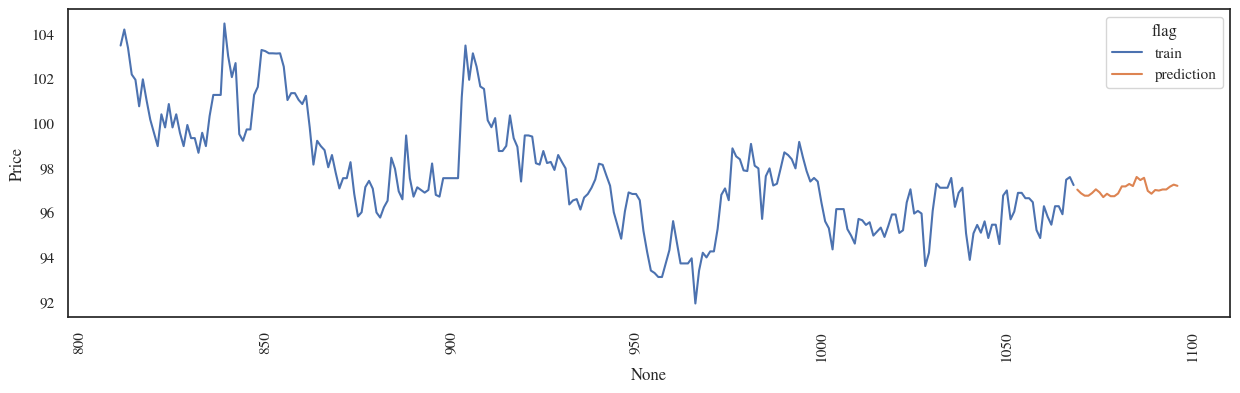

In [255]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))
sns.lineplot(data=df, x="Date", y="Price", ax=axes)
axes.tick_params(axis="x", labelrotation=90)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,4))
sns.lineplot(data=y_combined, x=y_combined.index, y="Price", hue="flag")
axes.tick_params(axis="x", labelrotation=90)
plt.show()